#### 1. **Model Runner Step Sync And Async Testing**

Notebook tests serving graph `ModelRunnerStep` feature with sync engine.

In [1]:
# Import mlrun and create project instance
import mlrun

image = "mlrun/mlrun"
project_name = "model-runner-naive-sync-nug"
project = mlrun.get_or_create_project(project_name, context="./",user_project=True, allow_cross_project=True)

> 2025-10-27 08:33:20,201 [info] Loading project from path: {"path":"./","project_name":"model-runner-naive-sync-nug","user_project":true}
> 2025-10-27 08:33:34,647 [info] Project loaded successfully: {"path":"./","project_name":"model-runner-naive-sync-nug-matanz","stored_in_db":true}


In [2]:
# Import tools
import pandas as pd
from sklearn.svm import SVC
import pickle
from sklearn.datasets import load_iris
from mlrun.features import Feature

In [3]:
# Train simple SVM model on Iris dataset, save it and reformat the DS as list
iris = load_iris()
clf = SVC()           
clf.fit(iris.data, iris.target)
with open("SVM.pkl", "wb") as fh:
    pickle.dump(clf, fh)
iris_data = iris["data"].tolist()

# load the dataset again as a DF
iris = load_iris()
train_set = pd.DataFrame(
    iris["data"],
    columns=["sepal_length_cm", "sepal_width_cm", "petal_length_cm", "petal_width_cm"],
)

# Create a Model Artifact in the project using the trained model
model_name = "SVM"
model_artifact = project.log_model(
    model_name,
    model_file="SVM.pkl",
    training_set=train_set,
    framework="sklearn",
    outputs=[Feature(name="label")],
)

In [ ]:
%%writefile model_class.py
import mlrun
import numpy as np

from datetime import datetime
from mlrun.serving.states import Model, ModelSelector
from typing import Optional
from cloudpickle import load
from storey import MapClass



class MyModel(Model):
    def __init__(self, *args, artifact_uri: str = None, raise_exception = False, **kwargs):
        super().__init__(*args, artifact_uri=artifact_uri, raise_exception=raise_exception, **kwargs)
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, _ = self.get_local_model_path(".pkl")
        self.model = load(open(model_file, "rb"))
    
    def predict(self, body: dict, **kwargs) -> dict:
        """Generate model predictions from sample."""
        print("sync")
        feats = np.asarray(body["inputs"]["here"])
        result: np.ndarray = self.model.predict(feats)
        return {"outputs": {"label" :result.tolist()}}

    async def predict_async(self, body: dict, **kwargs) -> dict:
        """Generate model predictions from sample."""
        print("async")
        feats = np.asarray(body["inputs"]["here"])
        result: np.ndarray = self.model.predict(feats)
        return {"outputs": {"label" :result.tolist()}}

    
class MyModelSelector(ModelSelector):
    def __init__(self, name:str):
        super().__init__()
        self.name = name
    
    """Selector allows the ModelRunnerStep to run some of models provided based on the event"""
    def select(self, event, available_models: list[Model]) -> Optional[list[str]]:
        return event.body.get("models")
    
    
class MyEnrichStep(MapClass):
    def do(self, event):
        event["timestamp"] = str(datetime.now().timestamp())
        return event


class MyPreprocessStep(MapClass):
    def do(self, event):
        inputs = event.pop("inputs")
        event["inputs"] = {"here": inputs}
        return event
        

#### 5. Define your function and ModelRunnerStep



In [4]:
# Config the code path and the serving function sync and async
sync_code_path = r"model_class_sync.py"

sync_function = project.set_function(func=sync_code_path,image="mlrun/mlrun",kind="serving",name="sync")

#### Use execution_mechanism=naive this time

In [5]:
from mlrun.serving.states import ModelRunnerStep

model_runner_step = ModelRunnerStep(
    name="my_runner", model_selector="MyModelSelector",model_selector_parameters={"name":"my-selector"})

for i in range(10):
    model_runner_step.add_model(
        model_class="MyModel",
        endpoint_name=f"my-{i}-model",
        model_artifact=model_artifact,
        input_path="inputs.here",
        result_path="outputs",
        outputs=["label"],
        execution_mechanism="naive",
    )

#### 6. Build graph


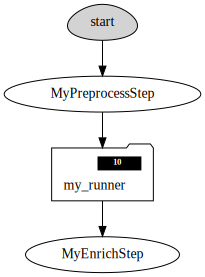

In [6]:
sync_graph = sync_function.set_topology("flow",engine="sync")
sync_graph.to("MyPreprocessStep").to(model_runner_step).to("MyEnrichStep").respond()
sync_graph.plot()

#### Run using mock



In [7]:
# 4. create mock server and test it locally (no k8s / deployment)
sync_mock_server = sync_function.to_mock_server()

> 2025-10-27 08:33:37,139 [info] Server graph after adding system steps: {"graph":"{'MyPreprocessStep': {'class_name': 'MyPreprocessStep', 'kind': 'task'}, 'my_runner': {'class_name': 'mlrun.serving.ModelRunner', 'class_args': {'model_selector': ('MyModelSelector', {'name': 'my-selector'}), execution_mechanism_by_model_name: {'my-0-model': 'naive', 'my-1-model': 'naive', 'my-2-model': 'naive', 'my-3-model': 'naive', 'my-4-model': 'naive', 'my-5-model': 'naive', 'my-6-model': 'naive', 'my-7-model': 'naive', 'my-8-model': 'naive', 'my-9-model': 'naive'}, models: {'my-0-model': ('MyModel', {'artifact_uri': 'store://models/model-runner-naive-sync-nug-matanz/SVM#0@3d3cdbf3-1643-425b-92f0-2fe9d61b993c^0a4bc48100972c80b49bcec8e55586e55c997b99', 'name': 'my-0-model'}), 'my-1-model': ('MyModel', {'artifact_uri': 'store://models/model-runner-naive-sync-nug-matanz/SVM#0@3d3cdbf3-1643-425b-92f0-2fe9d61b993c^0a4bc48100972c80b49bcec8e55586e55c997b99', 'name': 'my-1-model'}), 'my-2-model': ('MyModel'

In [8]:
sync_mock_server

In [10]:
from random import choice
from datetime import datetime

iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")


print("Before sync_function invoke:", datetime.now().strftime("%H:%M:%S.%f"))
mock_sync_response = sync_mock_server.test(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
print("After invoke:", datetime.now().strftime("%H:%M:%S.%f"))

Data point:[5.0, 3.4, 1.5, 0.2]
Before sync_function invoke: 08:35:28.677913
> 2025-10-27 08:35:28,687 [error] run error, Traceback (most recent call last):
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/serving/server.py", line 323, in run
    response = self.graph.run(event, **(extra_args or {}))
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/serving/states.py", line 2693, in run
    raise exc
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/serving/states.py", line 2685, in run
    event = next_obj.run(event, *args, **kwargs)
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/serving/states.py", line 878, in run
    raise exc
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/serving/states.py", line 864, in run
    raise MLRunInvalidArgumentError(
mlrun.errors.MLRunInvalidArgumentError: step my_runner does not have a handler


RuntimeError: failed (400): MLRunInvalidArgumentError: step my_runner does not have a handler

In [14]:
import asyncio

In [17]:
await asyncio.sleep(6)

In [ ]:
mock_sync_response

#### 7. Deploying graph

In [11]:
sync_function.deploy()

> 2025-10-27 08:35:37,508 [info] Starting remote function deploy
2025-10-27 08:35:37  (info) Deploying function
2025-10-27 08:35:37  (info) Building
2025-10-27 08:35:37  (info) Staging files and preparing base images
2025-10-27 08:35:37  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-10-27 08:35:37  (info) Building processor image
2025-10-27 08:37:03  (info) Build complete
2025-10-27 08:37:37  (info) Function deploy complete
> 2025-10-27 08:37:38,785 [info] Model endpoint creation task completed with state succeeded
> 2025-10-27 08:37:38,786 [info] Successfully deployed function: {"external_invocation_urls":["model-runner-naive-sync-nug-matanz-sync.default-tenant.app.cust-cs-il.iguazio-cd0.com/"],"internal_invocation_urls":["nuclio-model-runner-naive-sync-nug-matanz-sync.default-tenant.svc.cluster.local:8080"]}


'http://model-runner-naive-sync-nug-matanz-sync.default-tenant.app.cust-cs-il.iguazio-cd0.com/'

In [12]:
from random import choice
from datetime import datetime

iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")


print("Before sync_function invoke:", datetime.now().strftime("%H:%M:%S.%f"))
sync_response = sync_function.invoke(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)
print("After invoke:", datetime.now().strftime("%H:%M:%S.%f"))

Data point:[5.6, 3.0, 4.1, 1.3]
Before sync_function invoke: 08:37:39.026259


RuntimeError: bad function response 400: MLRunInvalidArgumentError: step my_runner does not have a handler

In [ ]:
sync_response

#### we can see the runtime error bad function response 400: MLRunInvalidArgumentError: step my_runner does not have a handler
same error for mock and deployment